Based on https://docs.rapids.ai/deployment/stable/examples/xgboost-dask-databricks/notebook/

Import all the relevant dependencies

In [1]:
import os
from xgboost import dask as dxgb
from dask_ml.model_selection import train_test_split
import numpy as np
import numba, socket, time
import dask, dask_cudf
from dask_cuda import LocalCUDACluster
import xgboost as xgb
from dask.distributed import Client, wait
import dask.array as da
from cuml.metrics import confusion_matrix, accuracy_score
import cupy as cp
import cudf
import pandas as pd
import cupy as cp
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import time
from cuml.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from cuml.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline


Set up and connect to Dask Client

In [2]:
dask.config.set({'distributed.rmm.pool-size': "30GB"})
dask.config.set({'distributed.ucx.cuda_copy': "True"})
dask.config.set({'distributed.ucx.nvlink': "True"})
dask.config.set({'distributed.ucx.infiniband': "True"})
dask.config.set({'distributed.ucx.net-devices': "ib0"})


In [3]:
os.environ["DASK_LOGGING__DISTRIBUTED"]="info"
os.environ["DASK_DISTRIBUTED__COMM__UCX__CREATE_CUDA_CONTEXT"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__CUDA_COPY"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__TCP"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__NVLINK"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__INFINIBAND"]="True"
os.environ["DASK_DISTRIBUTED__COMM__UCX__RDMACM"]="True"
os.environ["UCX_MEMTYPE_REG_WHOLE_ALLOC_TYPES"]="cuda"
os.environ["UCX_MEMTYPE_CACHE"]="n"


In [4]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=[0, 1, 2, 3], 
                           n_workers=4, threads_per_worker=8, 
                           protocol="ucx", interface="ib0",
                           enable_tcp_over_ucx=True, enable_infiniband=True, enable_nvlink=True, enable_rdmacm=True,
                           rmm_pool_size="30GB",)

client = Client(cluster)


print client informations

In [5]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://10.128.7.213:8787/status,
Dashboard: http://10.128.7.213:8787/status,Workers: 4
Total threads: 32,Total memory: 450.00 GiB
Status: running,Using processes: True
Comm: ucx://10.128.7.213:51088,Workers: 4
Dashboard: http://10.128.7.213:8787/status,Total threads: 32
Started: Just now,Total memory: 450.00 GiB
Comm: ucx://10.128.7.213:44414,Total threads: 8
Dashboard: http://10.128.7.213:34579/status,Memory: 112.50 GiB
Nanny: ucx://10.128.7.213:59947,


# Read the dataset

Now, we load the data using dask-cudf

In [6]:
ddf = dask_cudf.read_csv("data/HIGGS.csv")
colnames = ['process',     'lepton_pT',   'lepton_eta',  'lepton_phi',  
            'missing_energy_magnitude',   'missing_energy_phi', 
            'jet_1_pt',    'jet_1_eta',   'jet_1_phi',   'jet_1_b_tag', 
            'jet_2_pt',    'jet_2_eta',   'jet_2_phi',   'jet_2_b_tag',
            'jet_3_pt',    'jet_3_eta',   'jet_3_phi',   'jet_3_b_tag', 
            'jet_4_pt',    'jet_4_eta',   'jet_4_phi',   'jet_4_b_tag',
            'm_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

ddf.columns = colnames


In [7]:
ddf.head()

,process,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


In [8]:
ddf.shape

(<dask_expr.expr.Scalar: expr=(ColumnsSetter(frame=ArrowStringConversion(frame=FromMap(2efed3e)), columns=['process', 'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'])).size() // 29, dtype=int64>,
 29)

# Split data
Now use train_test_split() function from dask-ml to split up the dataset.

Most of the time, the GPU backend of Dask works seamlessly with utilities in dask-ml and we can accelerate the entire ML pipeline as such:


In [9]:
# Define a function that, given the dataset dask_cudf.core.DataFrame, returns a train and validation sets for the training with XGBoost
def load_higgs(client, ddf) -> tuple[dask_cudf.core.DataFrame,dask_cudf.core.Series,dask_cudf.core.DataFrame,dask_cudf.core.Series,]:
    y = ddf["process"]
    X = ddf[ddf.columns.difference(["process"])]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    X_train, X_valid, y_train, y_valid = client.persist([X_train, X_valid, y_train, y_valid])
    wait([X_train, X_valid, y_train, y_valid])
    return X_train, X_valid, y_train, y_valid


In [10]:
X_train, X_valid, y_train, y_valid = load_higgs(client, ddf)


In [11]:
X_train.head()

,jet_1_b_tag,jet_1_eta,jet_1_phi,jet_1_pt,jet_2_b_tag,jet_2_eta,jet_2_phi,jet_2_pt,jet_3_b_tag,jet_3_eta,...,lepton_phi,m_bb,m_jj,m_jjj,m_jlv,m_lv,m_wbb,m_wwbb,missing_energy_magnitude,missing_energy_phi
0,2.173076,-0.557525,-1.588230,1.095531,2.214872,-0.213642,1.271015,0.812581,0.000000,-1.261432,...,0.359412,0.779732,0.302220,0.833048,0.978098,0.985700,0.992356,0.798343,1.497970,-0.313010
1,0.000000,1.282322,1.381664,1.104875,2.214872,1.540659,-0.819690,0.851737,2.548224,0.356080,...,-1.635975,0.803252,0.909753,1.108330,0.951331,0.985692,0.865924,0.780118,0.453773,0.425629
3,0.000000,-1.070464,-0.921871,0.681466,2.214872,1.020974,0.971407,0.800872,0.000000,-0.350273,...,1.522401,1.133295,0.755856,1.361057,0.838085,0.986610,0.872245,0.808487,0.882808,-1.205349
10,2.173076,-0.355518,-1.717399,0.961051,0.000000,-0.481741,-1.199193,0.620956,0.000000,0.081185,...,0.829934,1.250979,0.944536,1.026261,0.542115,0.982197,0.830045,0.761308,0.504539,-0.130217
11,2.173076,0.877318,1.276887,1.019863,0.000000,1.409523,-1.474389,0.331252,0.000000,0.737474,...,-1.179879,0.861141,0.959325,0.807376,1.221210,1.191814,0.929341,0.838302,0.762913,-0.079782


In [12]:
X_train.shape

(<dask_expr.expr.Scalar: expr=FromGraph(4dfc217).size() // 28, dtype=int64>,
 28)

In [13]:
y_train.head()

0     1.0
1     1.0
3     1.0
10    0.0
11    1.0
Name: process, dtype: float64

In [14]:
y_train.shape

(<dask_expr.expr.Scalar: expr=FromGraph(3da7a2e).size(), dtype=int64>,)

# Model training


Given the train and validation sets, we train the XGBoost using a binary:logistic loss

By setting eval_metric='error', we can monitor the model's performance during training and enable early stopping to prevent overfitting. 

This metric is particularly useful when you want to minimize the overall misclassification rate.

XGBoost has 3 builtin tree methods, namely exact, approx and hist

- exact: During split-finding, it iterates over all entries of input data.  It's more accurate (among other greedy methods) but computationally slower in compared to other tree methods. Features like distributed training and external memory that require approximated quantiles are not supported.  As exact tree method is slow in computation performance and difficult to scale, we often employ approximated training algorithms.


- approx: An approximation tree method that runs sketching before building each tree using all the rows (rows belonging to the root). Hessian is used as weights during sketch.

- hist: An approximation tree method that runs sketching before training using only user provided weights instead of hessian. The subsequent per-node histogram is built upon this global sketch. This is the fastest algorithm as it runs sketching only once. 
    

In [15]:
def fit_model_es(client, X, y, X_valid, y_valid) -> dxgb.Booster:
    # Firstly, we specify the number of rounds to trigger early stopping for training.
    # XGBoost will stop the training once the validation metric fails to improve in consecutive X rounds, 
    # where X is the number of rounds specified for early stopping.
    # early_stopping_rounds=10 to enable early stopping if the error rate doesn't improve for 10 consecutive rounds.
    early_stopping_rounds = 10 
    # Secondly, we use a data type called DaskDeviceQuantileDMatrix for training but DaskDMatrix for validation.
    # DaskDeviceQuantileDMatrix is a drop-in replacement of DaskDMatrix for GPU-based training inputs that avoids extra data copies.
    # DaskDMatrix acts like normal DMatrix, works as a proxy for local DMatrix scatter around workers.
    Xy_valid = dxgb.DaskDMatrix(client, X_valid, y_valid)
    # DaskDeviceQuantileDMatrix is a data type specialized for gpu_hist, tree method that reduces memory overhead. 
    # When training on GPU pipeline, it'spreferred over DaskDMatrix
    Xy = dxgb.DaskDeviceQuantileDMatrix(client, X, y)
    # DaskDeviceQuantileDMatrix is used instead of DaskDMatrix, be careful that it can not be used for anything else other than training.
    # Train the model:
    # Use train method from xgboost.dask instead of xgboost.  
    # This distributed version of train returns a dictionary containing the resulting booster and evaluation history obtained from evaluation metrics.
    booster = dxgb.train(
        client,
        {"objective": "binary:logistic", "eval_metric": "error", "tree_method": "hist", "device" : "cuda",},
        Xy,
        evals=[(Xy_valid, "Valid")],
        num_boost_round=2000, # Number of boosting iterations
        early_stopping_rounds=early_stopping_rounds,
    )["booster"]
    return booster



### Train with Customized objective and evaluation metric

In the example below the XGBoost model is trained using
- a custom logistic regression-based objective function (logit) and

- a custom evaluation metric (error) along with early stopping.

Note that the function returns both gradient and hessian, which XGBoost uses to optimize the model.

Also, the parameter named metric_name needs to be specified in our callback.

It is used to inform XGBoost that the custom error function should be used for evaluating early stopping criteria.


In [16]:
def fit_model_customized_objective(client, X, y, X_valid, y_valid) -> dxgb.Booster:
    def logit(predt: np.ndarray, Xy: xgb.DMatrix) -> tuple[np.ndarray, np.ndarray]:
        predt = 1.0 / (1.0 + np.exp(-predt))
        labels = Xy.get_label()
        grad = predt - labels
        hess = predt * (1.0 - predt)
        return grad, hess

    def error(predt: np.ndarray, Xy: xgb.DMatrix) -> tuple[str, float]:
        label = Xy.get_label()
        r = np.zeros(predt.shape)
        predt = 1.0 / (1.0 + np.exp(-predt))
        gt = predt > 0.5
        r[gt] = 1 - label[gt]
        le = predt <= 0.5
        r[le] = label[le]
        return "CustomErr", float(np.average(r))

    # Use early stopping with custom objective and metric.
    early_stopping_rounds = 10
    # Specify the metric we want to use for early stopping.
    es = xgb.callback.EarlyStopping(rounds=early_stopping_rounds, save_best=True, metric_name="CustomErr")
    Xy = dxgb.DaskDeviceQuantileDMatrix(client, X, y)
    Xy_valid = dxgb.DaskDMatrix(client, X_valid, y_valid)
    booster = dxgb.train(
        client,
        {"eval_metric": "error", "tree_method": "hist", "device" : "cuda"},
        Xy,
        evals=[(Xy_valid, "Valid")],
        num_boost_round=2000, # Number of boosting iterations
        obj=logit,  # pass the custom objective
        custom_metric=error,  # pass the custom metric
        callbacks=[es],
    )["booster"]
    return booster


In [17]:
booster = fit_model_es(client, X=X_train, y=y_train, X_valid=X_valid, y_valid=y_valid)


[08:21:17] Task [xgboost.dask-2]:ucx://10.128.7.213:52735 got rank 2[08:21:17] Task [xgboost.dask-1]:ucx://10.128.7.213:41979 got rank 1

[08:21:17] Task [xgboost.dask-0]:ucx://10.128.7.213:44414 got rank 0
[08:21:17] Task [xgboost.dask-3]:ucx://10.128.7.213:34440 got rank 3
[08:21:18] [0]	Valid-error:0.33071
[08:21:18] [1]	Valid-error:0.31371
[08:21:18] [2]	Valid-error:0.30668
[08:21:18] [3]	Valid-error:0.30214
[08:21:18] [4]	Valid-error:0.29742
[08:21:18] [5]	Valid-error:0.29425
[08:21:18] [6]	Valid-error:0.29137
[08:21:18] [7]	Valid-error:0.28863
[08:21:18] [8]	Valid-error:0.28642
[08:21:18] [9]	Valid-error:0.28490
[08:21:18] [10]	Valid-error:0.28334
[08:21:18] [11]	Valid-error:0.28218
[08:21:18] [12]	Valid-error:0.28090
[08:21:18] [13]	Valid-error:0.28003
[08:21:18] [14]	Valid-error:0.27900
[08:21:18] [15]	Valid-error:0.27813
[08:21:18] [16]	Valid-error:0.27753
[08:21:18] [17]	Valid-error:0.27702
[08:21:18] [18]	Valid-error:0.27629
[08:21:18] [19]	Valid-error:0.27560
[08:21:18] [20

In [18]:
booster


In [19]:
# Train with Customized objective and evaluation metric
booster_custom = fit_model_customized_objective(client, X=X_train, y=y_train, X_valid=X_valid, y_valid=y_valid)


[08:21:28] Task [xgboost.dask-2]:ucx://10.128.7.213:52735 got rank 2[08:21:28] Task [xgboost.dask-1]:ucx://10.128.7.213:41979 got rank 1

[08:21:28] Task [xgboost.dask-0]:ucx://10.128.7.213:44414 got rank 0
[08:21:28] Task [xgboost.dask-3]:ucx://10.128.7.213:34440 got rank 3
[08:21:29] [0]	Valid-error:0.34944	Valid-CustomErr:0.41944
[08:21:29] [1]	Valid-error:0.33866	Valid-CustomErr:0.33830
[08:21:29] [2]	Valid-error:0.32938	Valid-CustomErr:0.31360
[08:21:29] [3]	Valid-error:0.32555	Valid-CustomErr:0.30496
[08:21:29] [4]	Valid-error:0.32199	Valid-CustomErr:0.29858
[08:21:29] [5]	Valid-error:0.31796	Valid-CustomErr:0.29442
[08:21:29] [6]	Valid-error:0.31491	Valid-CustomErr:0.29118
[08:21:29] [7]	Valid-error:0.31268	Valid-CustomErr:0.28841
[08:21:29] [8]	Valid-error:0.30999	Valid-CustomErr:0.28616
[08:21:30] [9]	Valid-error:0.30818	Valid-CustomErr:0.28492
[08:21:30] [10]	Valid-error:0.30608	Valid-CustomErr:0.28307
[08:21:30] [11]	Valid-error:0.30492	Valid-CustomErr:0.28188
[08:21:30] [12

In [20]:
booster_custom


# Running inference

In [21]:
# After some tuning, we arrive at the final model for performing inference on new data.
def predict(client, model, X):
    predt = dxgb.predict(client, model, X)
    return predt


def _sensitivity(y_actual, y_pred):
    """Calculate the sensitivity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    FN = cm[1, 0].item()
    TP = cm[1, 1].item()
    if(not TP): # avoid Nan values if both TP and FN are 0s
        sensitivity = 0.0
    else:
        sensitivity = round((TP / (TP + FN)), 5)
    return sensitivity


def _specificity(y_actual, y_pred):
    """Calculate the specificity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    TN = cm[0, 0].item()
    FP = cm[0, 1].item()
    if(not TN): # avoid Nan values if both TN and FP are 0s
        specificity = 0.0
    else:
        specificity = round((TN / (TN + FP)), 5)
    return specificity


def report(y_actual, y_pred, filename):
    """Print a report with all evaluation metrics for a model"""
    print(classification_report(y_actual.get(), y_pred.get()))
    sensitivity = _sensitivity(y_actual, y_pred)
    print('Sensitivity: ', sensitivity)
    specificity = _specificity(y_actual, y_pred)
    print('Specificity: ', specificity)
    cm_matrix = confusion_matrix(y_actual,y_pred)
    sns_plot=sns.heatmap(cm_matrix.get(), annot=True)
    sns_plot.figure.savefig(filename,dpi=600)
    plt.show()
    


In [22]:
y_preds = predict(client, booster, X_valid)
y_preds_custom = predict(client, booster_custom, X_valid)
y_preds_custom = 1.0 / (1.0 + np.exp(-y_preds_custom))
y_preds_p = y_preds.persist()
y_valid_p = y_valid.persist()
y_preds_custom_p = y_preds_custom.persist()
y_preds_p_label = y_preds_p.round().astype(int)
y_valid_p_label = y_valid_p.round().astype(int)
y_preds_custom_p_label=y_preds_custom_p.round().astype(int)
wait([y_valid_p_label, y_preds_p_label, y_preds_custom_p_label])


DoneAndNotDoneFutures(done={<Future: finished, type: cudf.core.series.Series, key: ('random_split_take-51afa8cb3c66020d91ea25c5350e1dcb', 19)>, <Future: finished, type: cudf.core.series.Series, key: ('mapped_predict-getitem-4c7994fd4dfdb01db93c436a3d998658', 18)>, <Future: finished, type: cudf.core.series.Series, key: ('mapped_predict-fused-truediv-089d97bc5e919477351aca126874c270', 6)>, <Future: finished, type: cudf.core.series.Series, key: ('random_split_take-51afa8cb3c66020d91ea25c5350e1dcb', 5)>, <Future: finished, type: cudf.core.series.Series, key: ('random_split_take-51afa8cb3c66020d91ea25c5350e1dcb', 29)>, <Future: finished, type: cudf.core.series.Series, key: ('random_split_take-51afa8cb3c66020d91ea25c5350e1dcb', 4)>, <Future: finished, type: cudf.core.series.Series, key: ('random_split_take-51afa8cb3c66020d91ea25c5350e1dcb', 22)>, <Future: finished, type: cudf.core.series.Series, key: ('mapped_predict-getitem-4c7994fd4dfdb01db93c436a3d998658', 29)>, <Future: finished, type: c

In [23]:
y_valid_p_label.head()


2    0
4    0
5    1
6    1
7    1
Name: process, dtype: int64

In [24]:
y_valid_p_label.shape


(<dask_expr.expr.Scalar: expr=(AsType(frame=Round(frame=FromGraph(e847d53), decimals=0), dtypes=<class 'int'>)).size(), dtype=int64>,)

In [25]:
y_preds_p_label.head()


2    1
4    0
5    1
6    1
7    1
Name: 0, dtype: int64

In [26]:
y_preds_p_label.shape


(<dask_expr.expr.Scalar: expr=(AsType(frame=Round(frame=FromGraph(50593ce), decimals=0), dtypes=<class 'int'>)).size(), dtype=int64>,)

In [27]:
y_preds_custom_p_label.head()


2    1
4    0
5    1
6    1
7    1
Name: 0, dtype: int64

In [28]:
y_preds_custom_p_label.shape


(<dask_expr.expr.Scalar: expr=(AsType(frame=Round(frame=FromGraph(3444210), decimals=0), dtypes=<class 'int'>)).size(), dtype=int64>,)

In [29]:
score = accuracy_score(y_valid_p_label, y_preds_p_label)
score_custom = accuracy_score(y_valid_p_label, y_preds_custom_p_label)
print(f"\nmodel accuracy: {score}\n", flush=True)
print(f"\ncustom model accuracy: {score_custom}\n", flush=True)



model accuracy: 0.7600349052161365


custom model accuracy: 0.7599660205931958



In [30]:
y_valid_c = y_valid_p.compute()
y_preds_c = y_preds_p.compute()
y_preds_custom_c = y_preds_custom_p.compute()

y_valid_c_label = y_valid_p.compute().round().astype(int)
y_preds_c_label = y_preds_p.compute().round().astype(int)
y_preds_custom_c_label = y_preds_custom_p.compute().round().astype(int)


In [31]:
y_valid_c.shape, y_preds_c.shape, y_preds_custom_c.shape

((3629257,), (3629257,), (3629257,))


model results:

              precision    recall  f1-score   support

           0       0.75      0.73      0.74   1705878
           1       0.77      0.79      0.78   1923379

    accuracy                           0.76   3629257
   macro avg       0.76      0.76      0.76   3629257
weighted avg       0.76      0.76      0.76   3629257

Sensitivity:  0.78516
Specificity:  0.73171


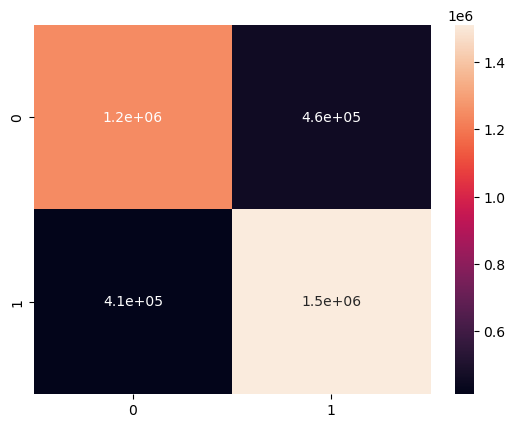

In [32]:
print("\nmodel results:\n", flush=True)
report(y_valid_c_label.to_cupy(), y_preds_c_label.to_cupy(), 'cm_matrix_plot.png')



custom model results:

              precision    recall  f1-score   support

           0       0.75      0.73      0.74   1705878
           1       0.77      0.79      0.78   1923379

    accuracy                           0.76   3629257
   macro avg       0.76      0.76      0.76   3629257
weighted avg       0.76      0.76      0.76   3629257

Sensitivity:  0.78524
Specificity:  0.73147


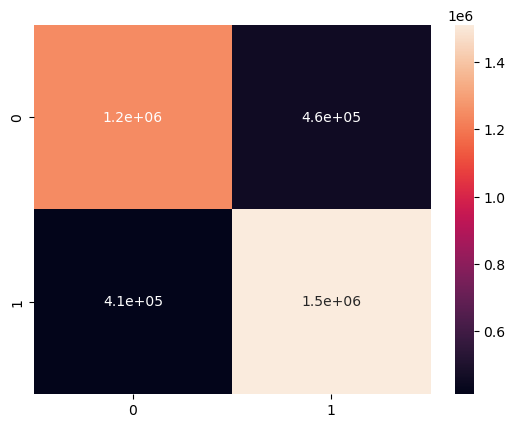

In [33]:
print("\ncustom model results:\n", flush=True)
report(y_valid_c_label.to_cupy(), y_preds_custom_c_label.to_cupy(), 'cm_matrix_plot.png')


In [35]:
roc_auc = roc_auc_score(y_valid_c_label.to_cupy(), y_preds_c.to_cupy())
roc_auc_custom = roc_auc_score(y_valid_c_label.to_cupy(), y_preds_custom_c.to_cupy())
print(f"\nmodel roc_auc: {roc_auc}\n", flush=True)
print(f"\ncustom model roc_auc: {roc_auc_custom}\n", flush=True)


model roc_auc: 0.8436511754989624


custom model roc_auc: 0.8435055017471313



# Clean up

When finished, be sure to destroy your cluster to avoid incurring extra costs for idle resources.


In [ ]:
client.close()